In [1]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [2]:
torch.cuda.is_available()

False

In [3]:

def calculate_metrics(amodal_mask_preds, 
                      amodal_mask_labels, 
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


### Model

#### Class

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()
        # downsampling
        self.mpool_2 = nn.MaxPool2d((2, 2))
        
        # down path - encoding - increase dimensions
        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2)
        
        # upsample by factor of 2, in both dimensions
        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)
        
        # up path - decoder
        # slowly reduce dimensions
        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        # no activation
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    
    # Packages the encoder path (downpath)
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        # Returns the four
        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    # packages the decode path (up-path)
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    # Encode - decode together
    # Runs through the whole model
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w) - batch size, channels, height, width
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        # This is what we use for loss calculations
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        # Compares raw logits for binary prediction - object vs no object
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels) # Binary Cross Entropy Loss
        # Pixel by pixel difference in the RGB
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels) # L1 loss
        return mask_loss, content_loss

#### Example Usage

Test model usage

In [22]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)

# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

Model output: torch.Size([1, 1, 256, 256]) torch.Size([1, 3, 256, 256])


### Training

#### Utils

In [6]:
torch.cuda.is_available() # flash has gpu available

False

In [23]:
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

# Send batch to device
def batch_to_device(batch, device):
    for key, value in batch.items():
        if key != 'metadata':
            batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the batches
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, train_dataloader, val_dataloader, n_epochs, device):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in range(n_epochs):
        print('Starting Epoch', epoch)
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%1 == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])
    
    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)



#### Demo Train

Using the provided architecture and calls

In [25]:
import matplotlib.pyplot as plt

In [26]:
import sys
sys.path.append("/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/groupj_llnl")
from load_data.load_dataset import MOVi_Dataset, MOVi_ImageDataset, MOVi_Dataset_Filtered
from torch.utils.data import DataLoader

In [27]:
try:
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
except:
    device = "cpu"
    
print(device)

cpu


In [29]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"

In [33]:
# Arguments
learning_rate = 1e-4 # 3e-4?... or 3e-5
batch_size = 8
mask_content_preds = True
n_workers = 4
n_epochs = 15

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_Filtered(split = 'train', 
                             n_frames = 1,
                             n_samples = 32, 
                             root=ROOT_PATH)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_Filtered(split = 'test', 
                           n_frames = 1,
                           n_samples = 8,
                          root=ROOT_PATH)
val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)
# val_dataset = train_dataset

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data/train/
Dataset init on test
Init data top dir: /Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data/test/


In [13]:
sample = next(iter(train_dataset))
sample

{'frames': tensor([[[[0.1059, 0.0941, 0.0941,  ..., 0.2667, 0.2667, 0.2392],
           [0.0980, 0.1059, 0.0980,  ..., 0.2588, 0.2588, 0.2471],
           [0.1098, 0.1020, 0.1020,  ..., 0.2627, 0.2588, 0.2471],
           ...,
           [0.6824, 0.6980, 0.6980,  ..., 0.4392, 0.4510, 0.4353],
           [0.6627, 0.6863, 0.6941,  ..., 0.4314, 0.4471, 0.4157],
           [0.6549, 0.6627, 0.6784,  ..., 0.4353, 0.4392, 0.4431]]],
 
 
         [[[0.1020, 0.0941, 0.0980,  ..., 0.2510, 0.2549, 0.2353],
           [0.0941, 0.0941, 0.0902,  ..., 0.2510, 0.2471, 0.2471],
           [0.0980, 0.0980, 0.0941,  ..., 0.2549, 0.2510, 0.2549],
           ...,
           [0.6980, 0.7059, 0.7098,  ..., 0.4353, 0.4353, 0.4353],
           [0.7059, 0.7059, 0.7098,  ..., 0.4275, 0.4235, 0.4275],
           [0.7098, 0.7098, 0.7137,  ..., 0.4471, 0.4431, 0.4471]]],
 
 
         [[[0.0784, 0.0706, 0.0627,  ..., 0.1686, 0.1804, 0.1922],
           [0.0667, 0.0667, 0.0627,  ..., 0.1686, 0.1647, 0.1647],
        

tensor(6.2385) tensor(18.2585)


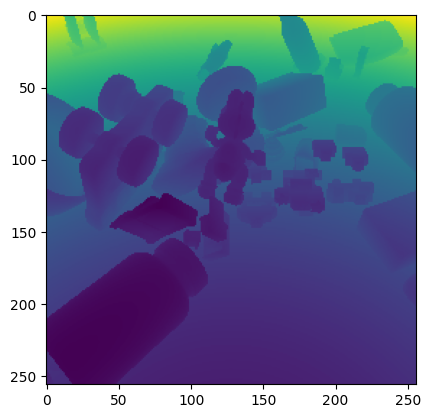

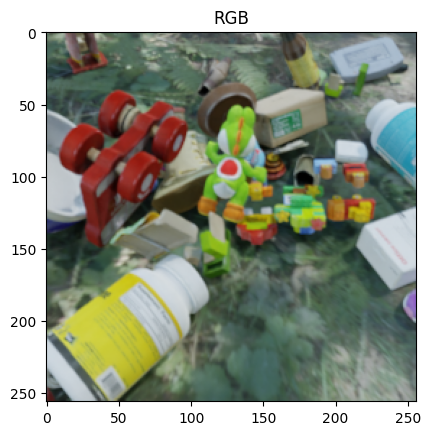

tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)


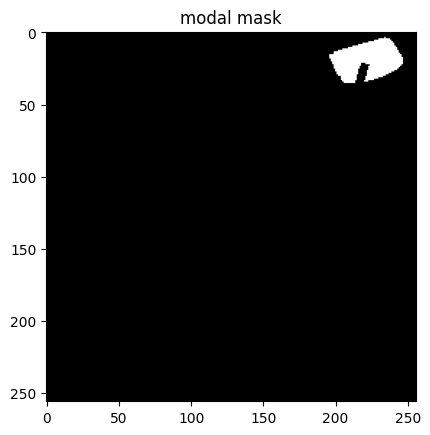

tensor(0.) tensor(1.)


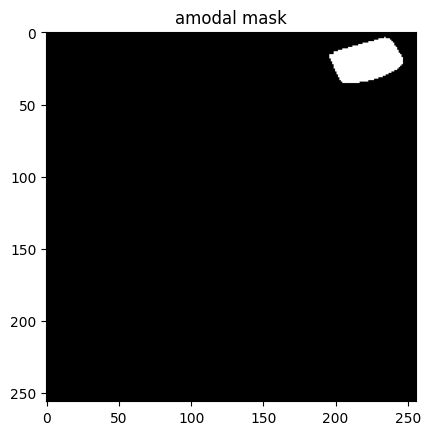

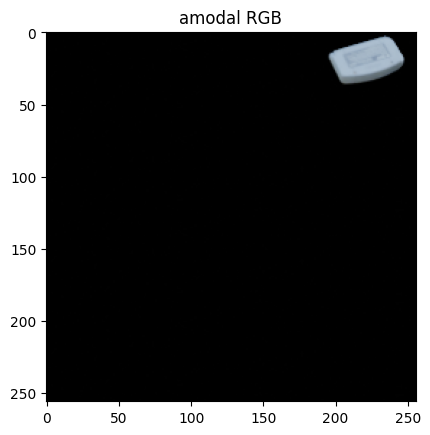

In [32]:
# 1. Take a random sample from your train dataset
idx = random.randint(0, len(val_dataset)-1)
sample = train_dataset[idx]  # sample is a dict

dep = sample['depths'][0][0]
print(dep.min(), dep.max())
plt.imshow(dep)
plt.show()

rgb = sample['frames'][:, 0].permute(1,2,0)
plt.imshow(rgb)
plt.title("RGB")
plt.show()

mmask = sample['modal_masks'][:, 0].permute(1,2,0)
print(mmask.min(), mmask.max())
plt.imshow(mmask, cmap='gray')
plt.title("modal mask")
plt.show()

amask = sample['amodal_masks'][:, 0].permute(1,2,0)
print(amask.min(), amask.max())
plt.imshow(amask, cmap='gray')
plt.title("amodal mask")
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.title("amodal RGB")
plt.show()

In [ ]:
true_mask = sample['modal_masks'].squeeze(1)
print(true_mask.min(), true_mask.max())
true_mask = true_mask.permute(1, 2, 0).cpu().numpy()
print(true_mask.shape)
plt.imshow(true_mask, cmap='gray')

In [34]:

"""
Our model is a torch model which contains the layers we will train.
This model takes the RGB image and the modal mask of an object (an attention cue) 
And will be trained to return the amodal (unobscured) mask as well as the amodal content.
Think of this as training for "x-ray vision" - given an attention cue, return what the unoccluded object
would look like, given hints from the image or video.

Extending this to video will be the next step, so start thinking about how you can combine
multiple frames of information to predict what an occluded object looks like.
"""
# Send to cuda
model = Unet_Image(in_channels = 4, mask_content_preds=True).to(device) # Object-wise ModalMask+RGB -> Object-wise AmodalMask+AmodalContent

# Optimizer - Adam
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Call the train function
list_of_train_metrics, list_of_valid_metrics = train(model, optim, train_dataloader, val_dataloader, n_epochs = n_epochs, device = device)

"""
While this trains, you should see the epoch performances greatly improving on the training split.
They may or may not improve on the validation split depending on many factors.
Now that this code runs though, try turning up the size of the datasets and see what affect that has.

Then eventually you can start designing a model intended to track and segment objects from video
which will require setting the datasets n_frames to a larger number, and re-designing your torch model.

Hopefully everything else remains working though! I would copy this notebook to have around for referce
Then make your own notebook where you experiment with new designs! :)
"""

Starting Epoch 0
Epoch 0 metrics:
+--------------------------+------------+--------------+
| Metric - Epoch 0         |   Training |   Validation |
+==========================+============+==============+
| loss                     |   0.960831 |     0.878831 |
+--------------------------+------------+--------------+
| mask_loss                |   0.743304 |     0.77369  |
+--------------------------+------------+--------------+
| content_loss             |   0.217527 |     0.105141 |
+--------------------------+------------+--------------+
| other_metrics_to_monitor |   0        |     0        |
+--------------------------+------------+--------------+
Starting Epoch 1
Epoch 1 metrics:
+--------------------------+------------+--------------+
| Metric - Epoch 1         |   Training |   Validation |
+==========================+============+==============+
| loss                     |   0.814323 |     0.838921 |
+--------------------------+------------+--------------+
| mask_loss         

'\nWhile this trains, you should see the epoch performances greatly improving on the training split.\nThey may or may not improve on the validation split depending on many factors.\nNow that this code runs though, try turning up the size of the datasets and see what affect that has.\n\nThen eventually you can start designing a model intended to track and segment objects from video\nwhich will require setting the datasets n_frames to a larger number, and re-designing your torch model.\n\nHopefully everything else remains working though! I would copy this notebook to have around for referce\nThen make your own notebook where you experiment with new designs! :)\n'

In [35]:
metrics = {'train': {}, 'validation': {}}
for key in list_of_train_metrics[0].keys():
    metrics['train'][key] = [list_of_train_metrics[i][key] for i in range(len(list_of_train_metrics))]

for key in list_of_valid_metrics[0].keys():
    metrics['validation'][key] = [list_of_valid_metrics[i][key] for i in range(len(list_of_valid_metrics))]

Text(0.5, 0, 'Epoch')

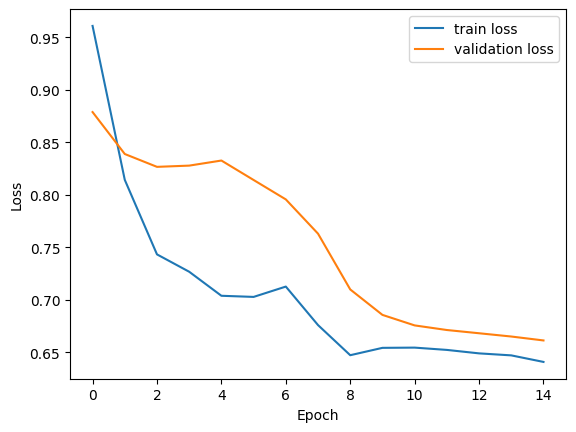

In [36]:
fig, ax = plt.subplots(1,1)

for key in ['train', 'validation']:
    ax.plot(metrics[key]['loss'], label=f'{key} loss')

ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

## Check random sample

frames torch.Size([3, 1, 256, 256])
depths torch.Size([1, 1, 256, 256])
modal_masks torch.Size([1, 1, 256, 256])
amodal_masks torch.Size([1, 1, 256, 256])
amodal_content torch.Size([3, 1, 256, 256])
Visualize:
tensor(5.2194) tensor(20.9970)


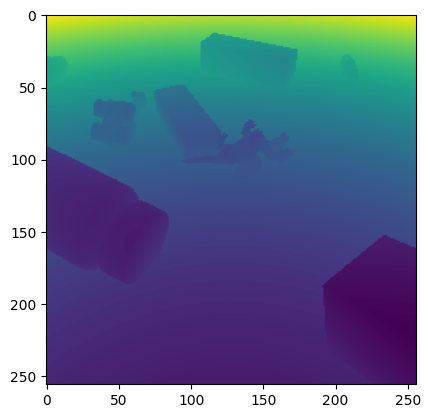

tensor(0.0510) tensor(0.8275) torch.Size([256, 256, 3])


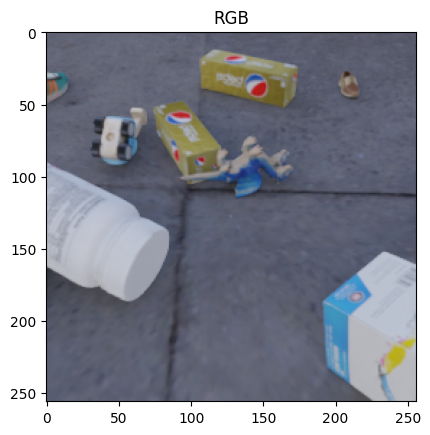

tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32) torch.Size([256, 256, 1])


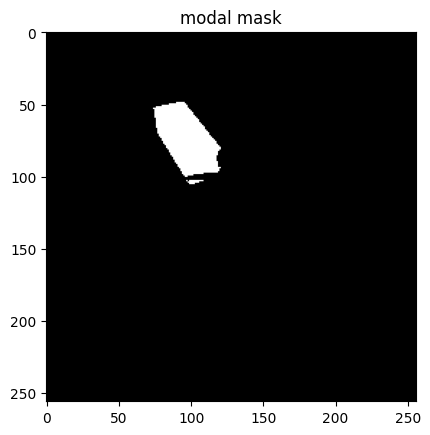

tensor(0.) tensor(1.) torch.Size([256, 256, 1])


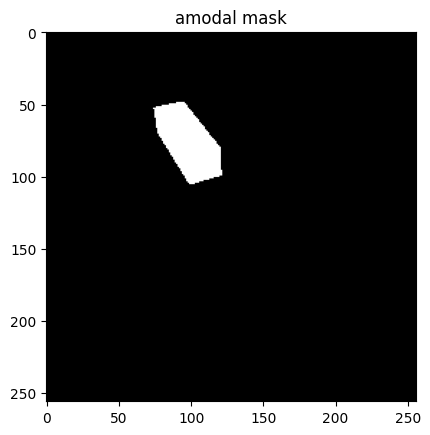

tensor(0, dtype=torch.uint8) tensor(208, dtype=torch.uint8) torch.Size([256, 256, 3])


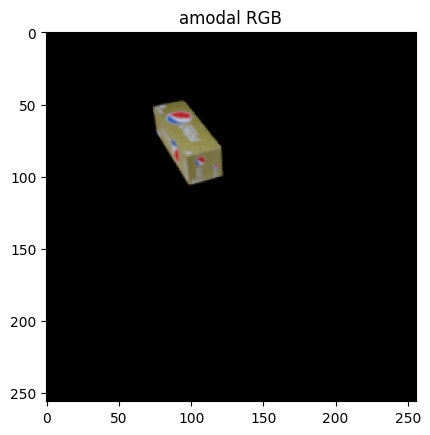

In [38]:
# 1. Take a random sample from your dataset
idx = random.randint(0, len(val_dataset)-1)
sample = val_dataset[idx]  # sample is a dict

for key in sample:
    if key != 'metadata':
        print(key, sample[key].shape)

# Prep ground truth data
# True depth
true_dep = sample['depths'][0][0]

# True sample RGB
# Currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
true_rgb_content = sample['frames'].squeeze(1).permute(1,2,0)

# Modal mask
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
true_modal_mask = sample['modal_masks'].squeeze(1).permute(1,2,0)

# Amodal mask
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
true_amodal_mask = sample['amodal_masks'].squeeze(1).permute(1,2,0)

# Amodal content
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
true_amodal_content = sample['amodal_content'].squeeze(1).permute(1,2,0)
true_amodal_content = (true_amodal_content * 255).to(torch.uint8)

# Visualize
print("Visualize:")
print(true_dep.min(), true_dep.max())
plt.imshow(true_dep)
plt.show()

print(true_rgb_content.min(), true_rgb_content.max(), true_rgb_content.shape)
plt.imshow(true_rgb_content)
plt.title("RGB")
plt.show()


print(true_modal_mask.min(), true_modal_mask.max(), true_modal_mask.shape)
plt.imshow(true_modal_mask, cmap='gray')
plt.title("modal mask")
plt.show()

print(true_amodal_mask.min(), true_amodal_mask.max(), true_amodal_mask.shape)
plt.imshow(true_amodal_mask, cmap='gray')
plt.title("amodal mask")
plt.show()

print(true_amodal_content.min(), true_amodal_content.max(), true_amodal_content.shape)
plt.imshow(true_amodal_content)
plt.title("amodal RGB")
plt.show()

#### Compare with batch

In [19]:
batch = next(iter(train_dataloader))
len(train_dataloader)

1

In [ ]:
print(batch['frames'].shape, batch['modal_masks'].shape)
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)

# concat rgb and modal masks as input to model - concat along channels dimension
model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)
print("model input after cat", model_input.shape)
# Remove time dimension from a few things (add it back in later when you make your video model!)
model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
print("final model input", model_input.shape) # bs, c, H, W (c=4, RGB+MM) 

# This is what we use for loss calculations
print("initial output shapes")
print("amodal masks", batch['amodal_masks'].shape, "range", batch['amodal_masks'].min(), batch['amodal_masks'].max())
print("amodal content", batch['amodal_content'].shape, "range",batch['amodal_content'].min(), batch['amodal_content'].max())

# Turn int right shape - lose the third dimension (n_frames) - time dimension!
amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
amodal_content_labels = batch['amodal_content'].float().squeeze(2)
print("amodal_mask_labels", amodal_mask_labels.shape, "range", amodal_mask_labels.min(), amodal_mask_labels.max())
print("amodal_content_labels", amodal_content_labels.shape, "range", amodal_content_labels.min(), amodal_content_labels.max())


Epoch 0: Loss=1.3685, Mask Loss=0.7809, Content Loss=0.5876
Epoch 100: Loss=0.6942, Mask Loss=0.6553, Content Loss=0.0389
Epoch 200: Loss=0.6295, Mask Loss=0.6018, Content Loss=0.0277
Epoch 300: Loss=0.5590, Mask Loss=0.5348, Content Loss=0.0243
Epoch 400: Loss=0.5172, Mask Loss=0.4958, Content Loss=0.0214
Epoch 500: Loss=0.4754, Mask Loss=0.4560, Content Loss=0.0193
Epoch 600: Loss=0.4409, Mask Loss=0.4231, Content Loss=0.0179
Epoch 700: Loss=0.4098, Mask Loss=0.3933, Content Loss=0.0165
Epoch 800: Loss=0.3813, Mask Loss=0.3666, Content Loss=0.0148
Epoch 900: Loss=0.3527, Mask Loss=0.3402, Content Loss=0.0125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.210962..41.29174].


Epoch 999: Loss=0.3281, Mask Loss=0.3171, Content Loss=0.0110


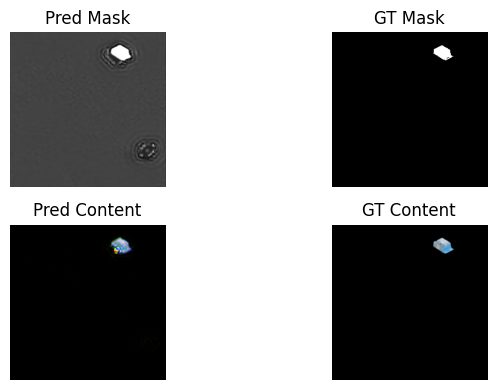

In [24]:
# Initialize model and optimizer
model = Unet_Image().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Overfit loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model(batch)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Loss={metrics['loss']:.4f}, Mask Loss={metrics['mask_loss']:.4f}, Content Loss={metrics['content_loss']:.4f}")

# Visualize predictions after training
model.eval()
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.encode_decode(
        torch.cat((batch['frames'], batch['modal_masks']), dim=1).squeeze(2)
    )
    pred_mask = torch.sigmoid(logits_amodal_mask).cpu().squeeze().numpy()
    pred_content = logits_amodal_content.cpu().squeeze().permute(1, 2, 0).numpy()
    gt_mask = batch['amodal_masks'].cpu().squeeze().numpy()
    gt_content = batch['amodal_content'].cpu().squeeze().permute(1, 2, 0).numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 1)
plt.title("Pred Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("GT Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("Pred Content")
plt.imshow(pred_content)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("GT Content")
plt.imshow(gt_content)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Run model

In [39]:
# Run the model
print("Frames + MMask Shape")
print(sample['frames'].shape, sample['modal_masks'].shape)


# Concatenate along batch dimension
# cat frames and modal_masks along the batch dimension - 1st element (channels)
# Second element (ix=1) is n_frames - we don't need that (time dimension)
model_input = torch.cat([sample['frames'], sample['modal_masks']], dim=0)  # [4, 1, 256, 256]
print("after cat", model_input.shape)

time_dim = 1 # ix=1 (n_frames)
# time dimension for a sample is different to a batch because a sample doesn't have batch size!
# Remove time dimension from a few things (add it back in later when you make your video model!)
model_input = model_input.squeeze(time_dim) # remove time dimension (you will probably want it later!)
print("Model input after squeezing n_frames dimension", model_input.shape)

# Reshape to [1, 4, 256, 256]
# Unsqueeze at zero dim - adds dimension
model_input = model_input.unsqueeze(0)  # [1, 4, 256, 256]
print("After unsqueeze at zero dim", model_input.shape)

# 3. Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
model_input = model_input.to(device)
print("Final model input", model_input.shape)
model_input

Frames + MMask Shape
torch.Size([3, 1, 256, 256]) torch.Size([1, 1, 256, 256])
after cat torch.Size([4, 1, 256, 256])
Model input after squeezing n_frames dimension torch.Size([4, 256, 256])
After unsqueeze at zero dim torch.Size([1, 4, 256, 256])
device: cpu
Final model input torch.Size([1, 4, 256, 256])


tensor([[[[0.4000, 0.4118, 0.4039,  ..., 0.3961, 0.3922, 0.3725],
          [0.3961, 0.4000, 0.3961,  ..., 0.3490, 0.3451, 0.3529],
          [0.3843, 0.3725, 0.3725,  ..., 0.3451, 0.3333, 0.3569],
          ...,
          [0.3490, 0.3412, 0.3412,  ..., 0.7137, 0.7216, 0.7020],
          [0.3412, 0.3490, 0.3373,  ..., 0.7098, 0.7176, 0.6902],
          [0.3608, 0.3490, 0.3373,  ..., 0.7059, 0.7020, 0.6510]],

         [[0.3961, 0.4118, 0.4235,  ..., 0.3922, 0.3765, 0.3843],
          [0.4039, 0.4000, 0.4039,  ..., 0.3569, 0.3529, 0.3608],
          [0.3961, 0.3843, 0.3843,  ..., 0.3529, 0.3490, 0.3725],
          ...,
          [0.3725, 0.3686, 0.3686,  ..., 0.7137, 0.7137, 0.7059],
          [0.3647, 0.3686, 0.3686,  ..., 0.7176, 0.7098, 0.7020],
          [0.3882, 0.3804, 0.3804,  ..., 0.7216, 0.7137, 0.6784]],

         [[0.4431, 0.4745, 0.4745,  ..., 0.4549, 0.4431, 0.4431],
          [0.4627, 0.4627, 0.4745,  ..., 0.4314, 0.4314, 0.4314],
          [0.4549, 0.4431, 0.4471,  ..., 0

In [40]:
# For loss calc
# Prep for loss calc
amodal_mask_labels = sample['amodal_masks'].float().squeeze(time_dim)
amodal_content_labels = sample['amodal_content'].float().squeeze(time_dim)

# Extend to simulate batch size, for loss calc
# needs input bs, c, h, w
# add a dimension for bs
amodal_mask_labels = amodal_mask_labels.unsqueeze(0)
amodal_content_labels = amodal_content_labels.unsqueeze(0)

print(amodal_content_labels.shape, amodal_mask_labels.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])


In [41]:
# 5. Evaluate using encode_decode
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.encode_decode(model_input)

print('logits_amodal_mask:', logits_amodal_mask.shape)
print('logits_amodal_content:', logits_amodal_content.shape)

# Evaluate loss
# Mask the content by where model predicts no object before loss calc
# Should we mask the amodal content prediction by the predicted amodal mask? 
# Element-wise masking by self-predictions:
logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content
# Loss between predicted amodal masks/content and GT masks/content
mask_loss, content_loss = model.loss_function(logits_amodal_mask, 
                                                amodal_mask_labels,
                                                logits_amodal_content, 
                                                amodal_content_labels)

loss = mask_loss + content_loss

# Report the metrics we calculated in addition to our loss functions
print(
f"""Loss on random sample:
loss {loss.data.item()}
mask_loss: {mask_loss.data.item()}
content_loss: {content_loss.data.item()},
""")


logits_amodal_mask: torch.Size([1, 1, 256, 256])
logits_amodal_content: torch.Size([1, 3, 256, 256])
Loss on random sample:
loss 0.6240103840827942
mask_loss: 0.6060294508934021
content_loss: 0.01798090711236,



### Plot model prediction on random sample

Turn the preds into exact same dimensions as ground truth, for plotting

Remember matplotlib RGB requirements - H, W, C

In [42]:
# For reference
# Remove time dimension and reorder into (H, W, C)
print("RGB", true_rgb_content.shape)

# Modal mask
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
print("Modal mask", true_modal_mask.shape)

# Amodal mask
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
print(true_amodal_mask.shape)

# Amodal RGB
# currently c, n_frames, h, w
# Remove time dimension and reorder into (H, W, C)
print(true_amodal_content.shape)

RGB torch.Size([256, 256, 3])
Modal mask torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 3])


In [43]:
# 1. RGB Content
print("AMODAL RGB CONTENT")
print("Logits amodal content, initial (after masking): logits amodal content shape", logits_amodal_content.shape, 
      "range", logits_amodal_content.min(), logits_amodal_content.max())

# These are masked amodal contents for the object
# Apply sigmoid to logits for amodal content (no rounding!)
logits_amodal_content = logits_amodal_content.sigmoid()
print("Logits amodal content, masked and sigmoid applied: logits amodal content shape", logits_amodal_content.shape, 
      "range", logits_amodal_content.min(), logits_amodal_content.max())

# Squeeze to remove the batch dimensions
preds_amodal_content = logits_amodal_content.squeeze(0)                   # [3, H, W]
print("Preds Amodal RGB, after squeeze: preds_amodal_content shape", 
      preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())


# Permute to send to matplotlib (H, W, C)
preds_amodal_content = preds_amodal_content.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
print("Preds Amodal RGB, after permute and numpy: preds_amodal_content shape", 
      preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())

# Apply clip
preds_amodal_content = np.clip(preds_amodal_content, 0, 1)

# Multiply by 255 to get color range
preds_amodal_content = (preds_amodal_content * 255).astype(np.uint8)     # [0, 255], uint8
print("Preds Amodal RGB, after multiply and int: preds_amodal_content shape", 
      preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())

print(f"AMODAL CONTENT: true {true_amodal_content.shape}, pred {preds_amodal_content.shape}")
print("range comparison\n", 
      f"true {true_amodal_content.min()}, {true_amodal_content.max()}\n",
      f"preds {preds_amodal_content.min()}, {preds_amodal_content.max()}\n")


# 2. Amodal Mask
print("AMODAL RGB MASK")

print("Logits amodal mask, initial: shape", logits_amodal_mask.shape, 
      "range", logits_amodal_mask.min(), logits_amodal_mask.max())

# Apply rounded sigmoids to get integers, binary
preds_amodal_mask = logits_amodal_mask.sigmoid().round().to(torch.uint8)
# This yields bs, c, h, w
print("Preds amodal mask, after sigmoid: shape", preds_amodal_mask.shape, 
      "range", preds_amodal_mask.min(), preds_amodal_mask.max())

# Drop ix = 0 (batch dimension)
preds_amodal_mask = preds_amodal_mask.squeeze(0)            # [1, H, W]
print("Preds amodal mask, after dropping bs: shape", preds_amodal_mask.shape, 
      "range", preds_amodal_mask.min(), preds_amodal_mask.max())


# permute to send to matplotlib (H, W, C) and send to numpy
preds_amodal_mask = preds_amodal_mask.permute(1, 2, 0).cpu().numpy()                 # For probability map (grayscale)
print("Preds amodal mask, after permute and send to numpy: shape", preds_amodal_mask.shape, 
      "range", preds_amodal_mask.min(), preds_amodal_mask.max())


print(f"AMODAL MASK: true {true_amodal_mask.shape}, pred {preds_amodal_mask.shape}")
print("range comparison\n", 
      f"true {true_amodal_mask.min()}, {true_amodal_mask.max()}\n",
      f"preds {preds_amodal_mask.min()}, {preds_amodal_mask.max()}\n")



AMODAL RGB CONTENT
Logits amodal content, initial (after masking): logits amodal content shape torch.Size([1, 3, 256, 256]) range tensor(-2.9058) tensor(2.4538)
Logits amodal content, masked and sigmoid applied: logits amodal content shape torch.Size([1, 3, 256, 256]) range tensor(0.0519) tensor(0.9208)
Preds Amodal RGB, after squeeze: preds_amodal_content shape torch.Size([3, 256, 256]) range tensor(0.0519) tensor(0.9208)
Preds Amodal RGB, after permute and numpy: preds_amodal_content shape (256, 256, 3) range 0.051869377 0.92083806
Preds Amodal RGB, after multiply and int: preds_amodal_content shape (256, 256, 3) range 13 234
AMODAL CONTENT: true torch.Size([256, 256, 3]), pred (256, 256, 3)
range comparison
 true 0, 208
 preds 13, 234

AMODAL RGB MASK
Logits amodal mask, initial: shape torch.Size([1, 1, 256, 256]) range tensor(-2.4172) tensor(9.5464)
Preds amodal mask, after sigmoid: shape torch.Size([1, 1, 256, 256]) range tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
P

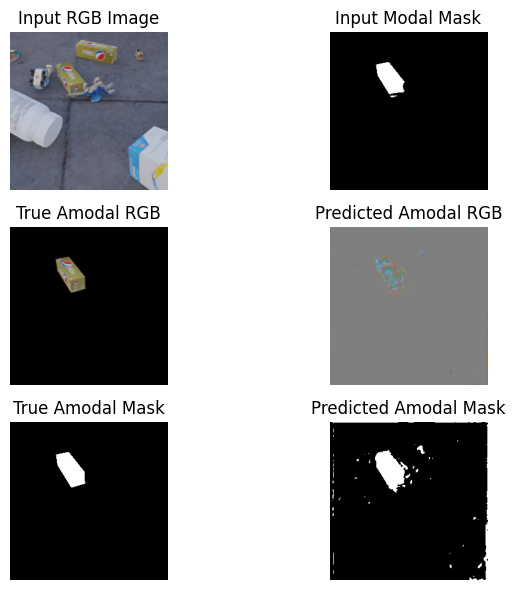

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(8, 6))

# RGB Image
ax = axs[0, 0]

ax.imshow(true_rgb_content)
ax.set_title("Input RGB Image")
ax.axis("off")

ax = axs[0, 1]
# If mask is in [0, 255], make it binary for visualization
# if mask.max() > 1:
#     mask = mask / 255.0  # scale to [0, 1]
ax.imshow(true_modal_mask, cmap='gray')
ax.set_title("Input Modal Mask")
ax.axis("off")

# True amodal RGB
ax = axs[1, 0]
ax.imshow(true_amodal_content)
ax.set_title("True Amodal RGB")
ax.axis("off")

# Pred amodal RGB
ax = axs[1, 1]
ax.imshow(preds_amodal_content)
ax.set_title("Predicted Amodal RGB")
ax.axis("off")

# True Amodal mask
ax = axs[2, 0]
ax.imshow(true_amodal_mask, cmap='gray')
ax.set_title("True Amodal Mask")
ax.axis("off")

# Pred amodal mask
ax = axs[2, 1]
ax.imshow(preds_amodal_mask, cmap='gray')
ax.set_title("Predicted Amodal Mask")
ax.axis("off")

plt.tight_layout()
plt.show()
